# Multilayer Perceptron

In [1]:
# Imports
import pandas as pd
import numpy as np
import joblib
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras

2022-06-13 16:06:07.388705: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-13 16:06:07.388720: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_theme(style='ticks', palette='viridis', rc={"axes.spines.right": False, "axes.spines.top": False})

In [3]:
# Data
X = pd.read_csv('data/train.csv')
y = X['TARGET_energy']
X.drop(columns=['TARGET_energy'], inplace=True)
X.head()

,date,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-02-20 13:20:00,21.530000,45.096667,20.600000,40.500000,21.474,42.40,18.323333,46.10,17.600000,54.264286,9.963333,92.656667,17.70,39.663333,20.650000,47.895000,17.70,44.200000,9.500000,755.000000,92.000000,5.333333,32.666667,8.200000,48.717990,48.717990
1,2016-01-23 06:20:00,17.290000,43.200000,16.356667,43.290000,17.700,41.20,15.300000,42.53,15.533333,48.961111,6.466667,99.900000,15.69,38.090000,16.655556,45.971667,15.19,42.433333,5.900000,766.866667,99.666667,4.000000,19.000000,5.833333,42.204855,42.204855
2,2016-04-02 09:50:00,20.890000,39.400000,18.790000,42.700000,21.790,37.40,19.790000,38.40,19.290000,45.090000,10.566667,37.993333,19.89,33.900000,21.200000,39.590000,19.60,37.730000,7.600000,757.983333,82.500000,1.833333,64.000000,4.716667,40.133645,40.133645
3,2016-02-07 12:40:00,21.133333,44.500000,20.500000,42.156667,21.500,43.59,18.790000,43.20,19.055556,59.102222,8.926667,64.193333,18.79,37.637778,20.890000,46.850556,19.10,44.933333,8.133333,745.966667,73.333333,8.333333,40.000000,3.533333,24.570344,24.570344
4,2016-04-21 19:50:00,23.000000,37.163333,22.500000,35.363333,23.200,36.40,22.890000,34.29,20.790000,41.290000,16.430000,1.000000,22.20,32.441429,23.000000,38.463333,20.20,35.730000,15.783333,759.516667,54.666667,4.000000,40.000000,6.566667,18.195913,18.195913


In [4]:
# Preprocessing
from transformers import DateTransformer, SimpleDateTransformer, CyclicalTransformer, AverageTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer

In [5]:
# Drop redundant features
drop = ('drop', ['rv1', 'rv2'])

# Transformation Columns for Average Transform
T_cols = [col for col in X.columns if re.search('T\d', col)]
RH_cols = [col for col in X.columns if re.search('RH_[1-4,7-9]', col)]

# Transformations
dt = DateTransformer(['date'])
ct = CyclicalTransformer(['date'])
sdt = SimpleDateTransformer(['date'])
t_at = AverageTransformer(T_cols, ['T_avg'])
rh_at = AverageTransformer(RH_cols, ['RH_avg'])

In [6]:
# Scalers
mms = MinMaxScaler()

In [7]:
# Preprocess and normalise data for MLP model
preprocess = make_column_transformer(drop, (dt, ['date']), remainder='passthrough')

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_mms = mms.fit_transform(preprocess.fit_transform(X_train))
X_val_mms = mms.fit_transform(preprocess.fit_transform(X_val))

## Multilayer Perceptron

In [8]:
model = keras.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=X_mms.shape[1:]),
    keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer='sgd', metrics=[tf.keras.metrics.RootMeanSquaredError(), tfa.metrics.r_square.RSquare()])
history = model.fit(X_mms, y, epochs=30, validation_split=0.1)

Epoch 1/30


2022-06-13 16:06:08.769920: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-13 16:06:08.769938: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-13 16:06:08.769951: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (knedliky): /proc/driver/nvidia/version does not exist
2022-06-13 16:06:08.770099: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


356/356 [==============================] - 1s 925us/step - loss: 12257.9033 - root_mean_squared_error: 110.7154 - r_square: -0.1136 - val_loss: 9829.6416 - val_root_mean_squared_error: 99.1445 - val_r_square: -1.1921e-07
Epoch 2/30
356/356 [==============================] - 0s 611us/step - loss: 11008.6748 - root_mean_squared_error: 104.9222 - r_square: -1.3745e-04 - val_loss: 9829.6465 - val_root_mean_squared_error: 99.1446 - val_r_square: -7.1526e-07
Epoch 3/30
356/356 [==============================] - 0s 601us/step - loss: 11011.4590 - root_mean_squared_error: 104.9355 - r_square: -3.9017e-04 - val_loss: 9829.8535 - val_root_mean_squared_error: 99.1456 - val_r_square: -2.1696e-05
Epoch 4/30
356/356 [==============================] - 0s 613us/step - loss: 11011.2930 - root_mean_squared_error: 104.9347 - r_square: -3.7503e-04 - val_loss: 9829.7031 - val_root_mean_squared_error: 99.1449 - val_r_square: -6.4373e-06
Epoch 5/30
356/356 [==============================] - 0s 587us/step - l

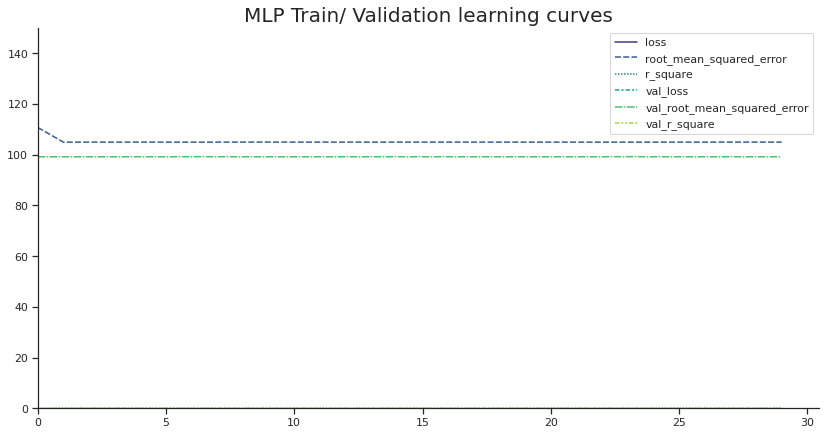

In [9]:
learning_curves = pd.DataFrame(history.history)

fig = plt.figure(figsize=(14,7))

sns.lineplot(data=learning_curves)

plt.title('MLP Train/ Validation learning curves', fontsize=20)
plt.ylim(0,150)
plt.xlim(0)
plt.show()

In [10]:
model.evaluate(X_val_mms, y_val)

99/99 [==============================] - 0s 496us/step - loss: 10560.7949 - root_mean_squared_error: 102.7657 - r_square: -1.8966e-04


[10560.794921875, 102.76573181152344, -0.00018966197967529297]

In [11]:
# Best model so far
model.save('models/mlp.h5')

## Hyperparameter Tuning
First we can try increasing the number of perceptrons in the first hidden layer.

In [12]:
model = keras.Sequential([
    keras.layers.Dense(50, activation='relu', input_shape=X_mms.shape[1:]),
    keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer='sgd', metrics=[tf.keras.metrics.RootMeanSquaredError(), tfa.metrics.r_square.RSquare()])
history = model.fit(X_mms, y, epochs=30, validation_split=0.1)

Epoch 1/30
356/356 [==============================] - 1s 853us/step - loss: 12679.6455 - root_mean_squared_error: 112.6039 - r_square: -0.1519 - val_loss: 9829.9795 - val_root_mean_squared_error: 99.1463 - val_r_square: -3.4571e-05
Epoch 2/30
356/356 [==============================] - 0s 602us/step - loss: 11011.3750 - root_mean_squared_error: 104.9351 - r_square: -3.8302e-04 - val_loss: 9830.7246 - val_root_mean_squared_error: 99.1500 - val_r_square: -1.1039e-04
Epoch 3/30
356/356 [==============================] - 0s 593us/step - loss: 11011.0596 - root_mean_squared_error: 104.9336 - r_square: -3.5453e-04 - val_loss: 9830.9629 - val_root_mean_squared_error: 99.1512 - val_r_square: -1.3459e-04
Epoch 4/30
356/356 [==============================] - 0s 616us/step - loss: 11011.9424 - root_mean_squared_error: 104.9378 - r_square: -4.3488e-04 - val_loss: 9834.4756 - val_root_mean_squared_error: 99.1689 - val_r_square: -4.9198e-04
Epoch 5/30
356/356 [==============================] - 0s 672

In [13]:
model.evaluate(X_val_mms, y_val)

99/99 [==============================] - 0s 573us/step - loss: 10561.9961 - root_mean_squared_error: 102.7716 - r_square: -3.0339e-04


[10561.99609375, 102.77157592773438, -0.0003033876419067383]

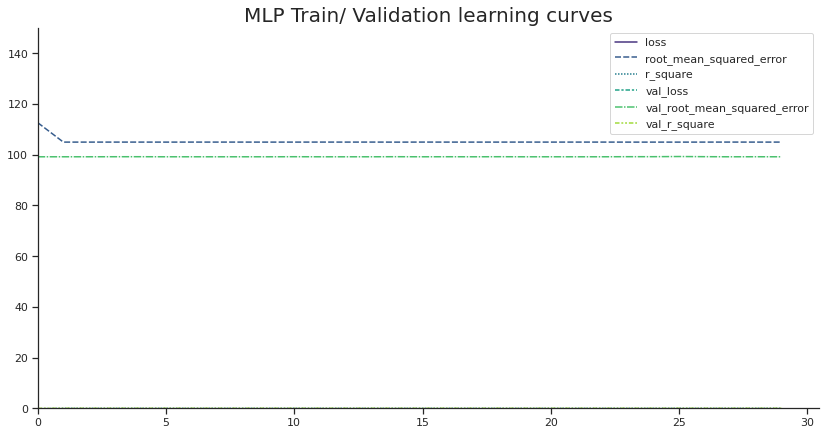

In [14]:
learning_curves = pd.DataFrame(history.history)

fig = plt.figure(figsize=(14,7))

sns.lineplot(data=learning_curves)

plt.title('MLP Train/ Validation learning curves', fontsize=20)
plt.ylim(0,150)
plt.xlim(0)
plt.show()

Adding more perceptrons to the hidden layer did not improve the model at all. Lets try adding another hidden layer, using a different activation function. 

In [15]:
model = keras.Sequential([
    keras.layers.Dense(30, activation='tanh', input_shape=X_mms.shape[1:]),
    keras.layers.Dense(30, activation='tanh'),
    keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer='sgd', metrics=[tf.keras.metrics.RootMeanSquaredError(), tfa.metrics.r_square.RSquare()])
history = model.fit(X_mms, y, epochs=30, validation_split=0.1)

Epoch 1/30
356/356 [==============================] - 1s 855us/step - loss: 11203.4932 - root_mean_squared_error: 105.8466 - r_square: -0.0178 - val_loss: 9867.5244 - val_root_mean_squared_error: 99.3354 - val_r_square: -0.0039
Epoch 2/30
356/356 [==============================] - 0s 621us/step - loss: 11130.7383 - root_mean_squared_error: 105.5023 - r_square: -0.0112 - val_loss: 10857.5986 - val_root_mean_squared_error: 104.1998 - val_r_square: -0.1046
Epoch 3/30
356/356 [==============================] - 0s 641us/step - loss: 11196.2510 - root_mean_squared_error: 105.8123 - r_square: -0.0172 - val_loss: 9885.3721 - val_root_mean_squared_error: 99.4252 - val_r_square: -0.0057
Epoch 4/30
356/356 [==============================] - 0s 623us/step - loss: 11190.5615 - root_mean_squared_error: 105.7855 - r_square: -0.0167 - val_loss: 9944.9326 - val_root_mean_squared_error: 99.7243 - val_r_square: -0.0117
Epoch 5/30
356/356 [==============================] - 0s 635us/step - loss: 11177.3340

In [16]:
model.evaluate(X_val_mms, y_val)

99/99 [==============================] - 0s 529us/step - loss: 10678.4062 - root_mean_squared_error: 103.3364 - r_square: -0.0113


[10678.40625, 103.33637237548828, -0.011328458786010742]

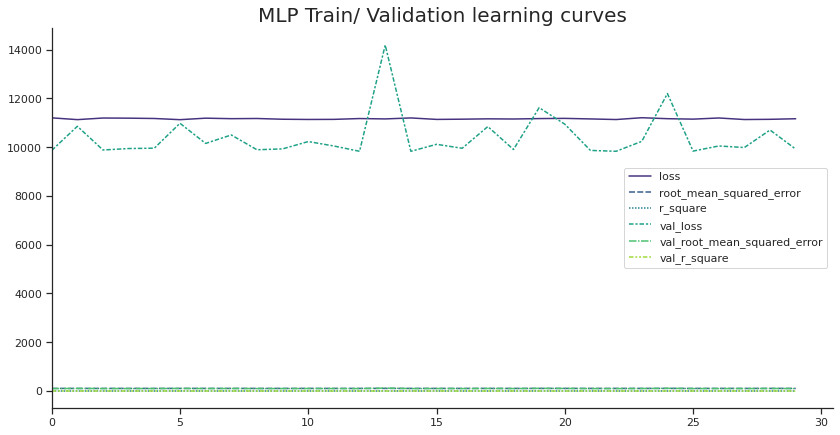

In [17]:
learning_curves = pd.DataFrame(history.history)

fig = plt.figure(figsize=(14,7))

sns.lineplot(data=learning_curves)

plt.title('MLP Train/ Validation learning curves', fontsize=20)
plt.xlim(0)
plt.show()

Adding another hidden layer did not improve the RMSE score. Interestingly, the r squared score increased, indicating that the model is able to explain more of the variance in the data. Let's add another layer, going back to the relu activation function to see if any further improvements can be made by making the model deeper.

In [18]:
model = keras.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=X_mms.shape[1:]),
    keras.layers.Dense(30, activation='relu'),
     keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer='sgd', metrics=[tf.keras.metrics.RootMeanSquaredError(), tfa.metrics.r_square.RSquare()])
history = model.fit(X_mms, y, epochs=30, validation_split=0.1)

Epoch 1/30
356/356 [==============================] - 1s 913us/step - loss: 3385865.2500 - root_mean_squared_error: 1840.0720 - r_square: -306.6056 - val_loss: 9842.4473 - val_root_mean_squared_error: 99.2091 - val_r_square: -0.0013
Epoch 2/30
356/356 [==============================] - 0s 654us/step - loss: 11011.8691 - root_mean_squared_error: 104.9375 - r_square: -4.2737e-04 - val_loss: 9829.6406 - val_root_mean_squared_error: 99.1445 - val_r_square: -1.1921e-07
Epoch 3/30
356/356 [==============================] - 0s 658us/step - loss: 11011.2520 - root_mean_squared_error: 104.9345 - r_square: -3.7110e-04 - val_loss: 9829.6934 - val_root_mean_squared_error: 99.1448 - val_r_square: -5.4836e-06
Epoch 4/30
356/356 [==============================] - 0s 683us/step - loss: 11011.5645 - root_mean_squared_error: 104.9360 - r_square: -3.9995e-04 - val_loss: 9829.6484 - val_root_mean_squared_error: 99.1446 - val_r_square: -8.3447e-07
Epoch 5/30
356/356 [==============================] - 0s 65

Here, I suspect the vanishing/ exploding gradient problem becomes an issue where back propogation through multiple layers of networks converges to 0 or explodes to an out of memory value, nullifying the weights of the model. We can try a different activation function to see if this helps.

In [19]:
model = keras.Sequential([
    keras.layers.Dense(30, activation='sigmoid', input_shape=X_mms.shape[1:]),
    keras.layers.Dense(30, activation='sigmoid'),
     keras.layers.Dense(10, activation='sigmoid'),
    keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer='sgd', metrics=[tf.keras.metrics.RootMeanSquaredError(), tfa.metrics.r_square.RSquare()])
history = model.fit(X_mms, y, epochs=30, validation_split=0.1)

Epoch 1/30
356/356 [==============================] - 1s 911us/step - loss: 11144.0342 - root_mean_squared_error: 105.5653 - r_square: -0.0124 - val_loss: 9847.9375 - val_root_mean_squared_error: 99.2368 - val_r_square: -0.0019
Epoch 2/30
356/356 [==============================] - 0s 641us/step - loss: 11044.6006 - root_mean_squared_error: 105.0933 - r_square: -0.0034 - val_loss: 10000.8213 - val_root_mean_squared_error: 100.0041 - val_r_square: -0.0174
Epoch 3/30
356/356 [==============================] - 0s 639us/step - loss: 11036.5605 - root_mean_squared_error: 105.0550 - r_square: -0.0027 - val_loss: 9892.8223 - val_root_mean_squared_error: 99.4627 - val_r_square: -0.0064
Epoch 4/30
356/356 [==============================] - 0s 634us/step - loss: 11050.8184 - root_mean_squared_error: 105.1229 - r_square: -0.0040 - val_loss: 9836.1670 - val_root_mean_squared_error: 99.1775 - val_r_square: -6.6400e-04
Epoch 5/30
356/356 [==============================] - 0s 647us/step - loss: 11052.

In [20]:
model.evaluate(X_val_mms, y_val)

99/99 [==============================] - 0s 509us/step - loss: 10560.4941 - root_mean_squared_error: 102.7643 - r_square: -1.6117e-04


[10560.494140625, 102.76426696777344, -0.00016117095947265625]

Changing the activation function worked, nonetheless, the model does not seem to improve by adding depth. Lets attempt making the model wider, by separating inputs and feeding them into the network. Separating the features by multicollinearity discovered in the exploratory analysis, and subject matter knowledge is the approach taken here. Temperature and humidity measurements taken within the home will be contained in one input, measurements from the external weather station will be another input, and time metrics taken from the date data will be a third. 

First lets attempt to feed one input to a wide path.

In [21]:
input_ = keras.layers.Input(shape=X_mms.shape[1:])
hidden1 = keras.layers.Dense(30, activation='sigmoid')(input_)
hidden2 = keras.layers.Dense(30, activation='sigmoid')(hidden1)
concat = keras.layers.Concatenate()([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.Model(inputs=[input_], outputs=[output])

In [22]:
model.compile(loss='mse', optimizer='sgd', metrics=[tf.keras.metrics.RootMeanSquaredError(), tfa.metrics.r_square.RSquare()])
history = model.fit(X_mms, y_train, epochs=30, validation_split=0.1)

Epoch 1/30
356/356 [==============================] - 1s 890us/step - loss: 9818.6328 - root_mean_squared_error: 99.0890 - r_square: 0.0930 - val_loss: 9544.6016 - val_root_mean_squared_error: 97.6965 - val_r_square: 0.0684
Epoch 2/30
356/356 [==============================] - 0s 637us/step - loss: 9505.3623 - root_mean_squared_error: 97.4954 - r_square: 0.1220 - val_loss: 8917.6260 - val_root_mean_squared_error: 94.4332 - val_r_square: 0.1296
Epoch 3/30
356/356 [==============================] - 0s 624us/step - loss: 9400.5986 - root_mean_squared_error: 96.9567 - r_square: 0.1316 - val_loss: 8627.9111 - val_root_mean_squared_error: 92.8866 - val_r_square: 0.1578
Epoch 4/30
356/356 [==============================] - 0s 627us/step - loss: 9316.7461 - root_mean_squared_error: 96.5233 - r_square: 0.1394 - val_loss: 9925.4844 - val_root_mean_squared_error: 99.6267 - val_r_square: 0.0312
Epoch 5/30
356/356 [==============================] - 0s 643us/step - loss: 9283.0049 - root_mean_square

In [23]:
model.evaluate(X_val_mms, y_val)

99/99 [==============================] - 0s 609us/step - loss: 8843.9111 - root_mean_squared_error: 94.0421 - r_square: 0.1624


[8843.9111328125, 94.04206848144531, 0.1624126434326172]

Using a sigmoid activation function, and a broad architectural approach yielded much better results than a deeper architecture.

In [24]:
# Best model so far
model.save('models/mlp.h5')

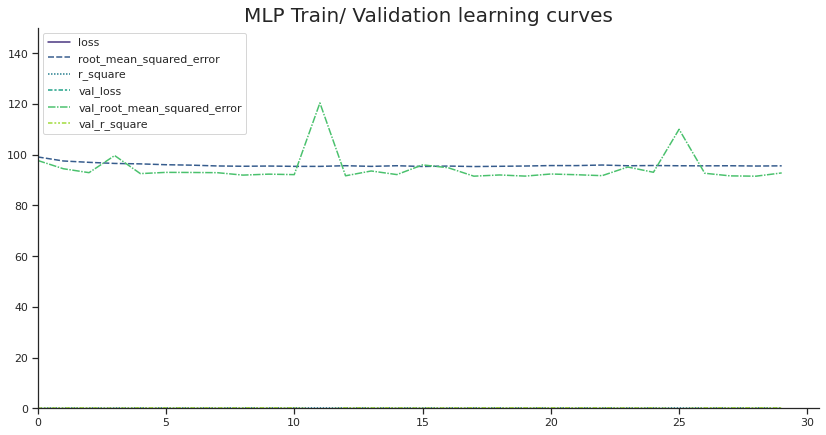

In [25]:
learning_curves = pd.DataFrame(history.history)

fig = plt.figure(figsize=(14,7))

sns.lineplot(data=learning_curves)

plt.title('MLP Train/ Validation learning curves', fontsize=20)
plt.ylim(0,150)
plt.xlim(0)
plt.show()

In [26]:
inside_cols = [col for col in X.columns if (re.search('T\d', col) or re.search('RH_\d', col))]
station_cols = ['Windspeed', 'Visibility', 'Tdewpoint', 'RH_out', 'Press_mm_hg', 'T_out']

input_inside = mms.fit_transform(X[inside_cols])
input_station = mms.fit_transform(X[station_cols])
input_time = mms.fit_transform(dt.fit_transform(X))

In [27]:
input_A = keras.layers.Input(shape=input_inside.shape[1:])
input_B = keras.layers.Input(shape=input_station.shape[1:])
input_C = keras.layers.Input(shape=input_time.shape[1:])

hidden1 = keras.layers.Dense(50, activation='sigmoid')(input_A)
hidden2 = keras.layers.Dense(50, activation='sigmoid')(input_B)
hidden3 = keras.layers.Dense(50, activation='sigmoid')(input_C)

concat1 = keras.layers.Concatenate()([hidden1, hidden2, hidden3])
concat2 = keras.layers.Concatenate()([input_A, concat1])

output = keras.layers.Dense(1)(concat2)
model = keras.Model(inputs=[input_A, input_B, input_C], outputs=[output])

In [28]:
model.compile(loss='mse', optimizer='sgd', metrics=[tf.keras.metrics.RootMeanSquaredError(), tfa.metrics.r_square.RSquare()])
history = model.fit((input_inside, input_station, input_time), y, epochs=30, validation_split=0.1)

Epoch 1/30
445/445 [==============================] - 1s 950us/step - loss: 9592.7334 - root_mean_squared_error: 97.9425 - r_square: 0.1112 - val_loss: 51603.2188 - val_root_mean_squared_error: 227.1634 - val_r_square: -4.0946
Epoch 2/30
445/445 [==============================] - 0s 749us/step - loss: 9515.4619 - root_mean_squared_error: 97.5472 - r_square: 0.1183 - val_loss: 8860.9951 - val_root_mean_squared_error: 94.1329 - val_r_square: 0.1252
Epoch 3/30
445/445 [==============================] - 0s 723us/step - loss: 9345.3887 - root_mean_squared_error: 96.6715 - r_square: 0.1341 - val_loss: 8767.1562 - val_root_mean_squared_error: 93.6331 - val_r_square: 0.1344
Epoch 4/30
445/445 [==============================] - 0s 693us/step - loss: 9230.2705 - root_mean_squared_error: 96.0743 - r_square: 0.1448 - val_loss: 8765.8877 - val_root_mean_squared_error: 93.6263 - val_r_square: 0.1346
Epoch 5/30
445/445 [==============================] - 0s 700us/step - loss: 9102.4570 - root_mean_squ

In [29]:
model.evaluate((input_inside, input_station, input_time), y)

494/494 [==============================] - 0s 573us/step - loss: 11979.8535 - root_mean_squared_error: 109.4525 - r_square: -0.1169


[11979.853515625, 109.4525146484375, -0.11686301231384277]

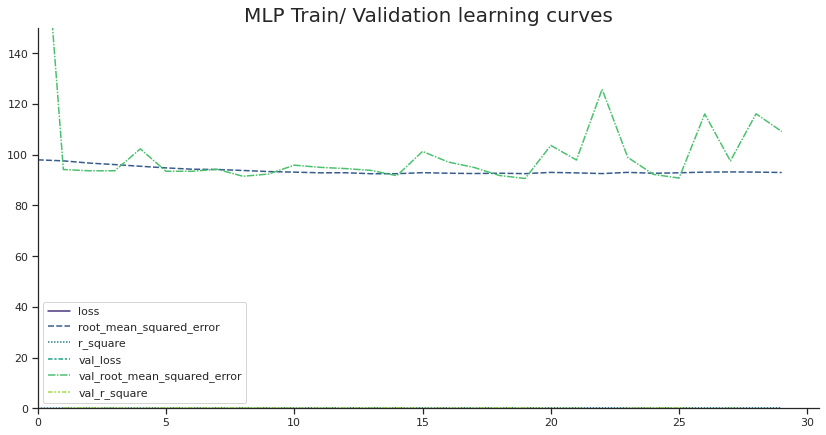

In [30]:
learning_curves = pd.DataFrame(history.history)

fig = plt.figure(figsize=(14,7))

sns.lineplot(data=learning_curves)

plt.title('MLP Train/ Validation learning curves', fontsize=20)
plt.ylim(0,150)
plt.xlim(0)
plt.show()

In [31]:
input_A = keras.layers.Input(shape=input_inside.shape[1:])
input_B = keras.layers.Input(shape=input_station.shape[1:])
input_C = keras.layers.Input(shape=input_time.shape[1:])

hidden1 = keras.layers.Dense(50, activation='sigmoid')(input_A)
hidden2 = keras.layers.Dense(50, activation='sigmoid')(input_B)
hidden3 = keras.layers.Dense(50, activation='sigmoid')(input_C)

concat = keras.layers.Concatenate()([hidden1, hidden2, hidden3])

output = keras.layers.Dense(1)(concat)
model = keras.Model(inputs=[input_A, input_B, input_C], outputs=[output])

In [32]:
model.compile(loss='mse', optimizer='sgd', metrics=[tf.keras.metrics.RootMeanSquaredError(), tfa.metrics.RSquare()])
history = model.fit((input_inside, input_station, input_time), y, epochs=30, validation_split=0.1)

Epoch 1/30
445/445 [==============================] - 1s 919us/step - loss: 9652.3340 - root_mean_squared_error: 98.2463 - r_square: 0.1057 - val_loss: 9007.2852 - val_root_mean_squared_error: 94.9067 - val_r_square: 0.1107
Epoch 2/30
445/445 [==============================] - 0s 684us/step - loss: 9404.3848 - root_mean_squared_error: 96.9762 - r_square: 0.1286 - val_loss: 10602.0488 - val_root_mean_squared_error: 102.9662 - val_r_square: -0.0467
Epoch 3/30
445/445 [==============================] - 0s 675us/step - loss: 9237.6094 - root_mean_squared_error: 96.1125 - r_square: 0.1441 - val_loss: 8832.8604 - val_root_mean_squared_error: 93.9833 - val_r_square: 0.1280
Epoch 4/30
445/445 [==============================] - 0s 706us/step - loss: 9085.6484 - root_mean_squared_error: 95.3187 - r_square: 0.1582 - val_loss: 11597.6504 - val_root_mean_squared_error: 107.6924 - val_r_square: -0.1450
Epoch 5/30
445/445 [==============================] - 0s 683us/step - loss: 8898.5146 - root_mean_

In [33]:
model.evaluate((input_inside, input_station, input_time), y)

494/494 [==============================] - 0s 571us/step - loss: 18212.3379 - root_mean_squared_error: 134.9531 - r_square: -0.6979


[18212.337890625, 134.95309448242188, -0.6979076862335205]

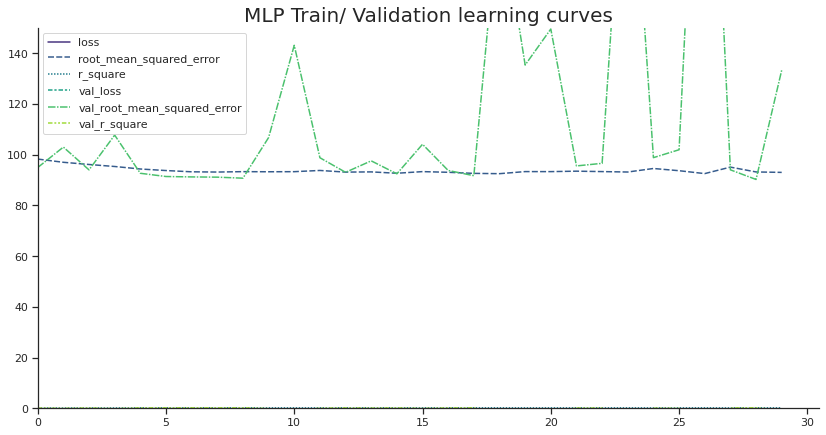

In [34]:
learning_curves = pd.DataFrame(history.history)

fig = plt.figure(figsize=(14,7))

sns.lineplot(data=learning_curves)

plt.title('MLP Train/ Validation learning curves', fontsize=20)
plt.ylim(0,150)
plt.xlim(0)
plt.show()

It seems that a broad approach seemed to work best with this dataset. The model does not seem to bne able to perform as well as other models, however, there could be further hyperparameter tuning implemented to further the optimise performance. It does not seem that this model will reach the performance of XGBoost however.